# Подключаем библиотеки

In [75]:
import xgboost as xgb
import pandas as pd
import numpy as np
from geopy.distance import geodesic 
import math
import os
from sklearn.metrics import mean_absolute_error, r2_score, median_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.externals import joblib
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 
import seaborn as sns
from datetime import datetime, date
import warnings
warnings.filterwarnings('ignore')
os.environ['KMP_DUPLICATE_LIB_OK']='True' 
from sklearn.metrics import explained_variance_score
import lightgbm as lgb

# Объявляем функции

In [76]:
def preprocess(dataframe):
    
    dataframe = dataframe.drop_duplicates('url', keep='last') #Удаляем дубликаты по признаку url и оставляем только последний из них
    dataframe = dataframe.drop_duplicates('description', keep='last') #Удаляем дубликаты по признаку description
    dataframe = dataframe.drop_duplicates(subset=['floorNumber', 'fullAddress', 'cianUserId'], keep='last') #Удаляем дубликаты по сочетанию признаков
    dataframe = dataframe.drop_duplicates(subset=['price', 'fullAddress', 'cianUserId'], keep='last') #Удаляем дубликаты по сочетанию признаков
    dataframe = dataframe.drop_duplicates(subset=['totalArea', 'fullAddress', 'phone'], keep='last') #Удаляем дубликаты по сочетанию признаков

    dataframe['kitchenArea'] = dataframe['kitchenArea'].replace({'None':np.NaN})
    dataframe.dropna(subset=['kitchenArea'],inplace=True)
    
    dataframe['totalArea'] = dataframe['totalArea'].str.replace(',', '.')
    dataframe['totalArea'] = pd.to_numeric(dataframe['totalArea'])
    
    dataframe['kitchenArea'] = dataframe['kitchenArea'].str.replace(',', '.')
    dataframe['kitchenArea'] = pd.to_numeric(dataframe['kitchenArea'])
    

    dataframe['priceMetr'] = dataframe['price']/dataframe['totalArea']
    dataframe['latitude'] = pd.to_numeric(dataframe['latitude'])
    dataframe['longitude'] = pd.to_numeric(dataframe['longitude'])

    dataframe.dropna(subset=['wallsMaterial'],inplace=True)
    dataframe.dropna(subset=['floorsTotal'],inplace=True)
  
    frame = dataframe.loc[0:,['wallsMaterial', 
                              'floorNumber', 
                              'floorsTotal', 
                              'totalArea', 
                              'kitchenArea',
                              'priceMetr', 
                              'price',
                              'latitude',
                              'longitude'
                              ]]
    
    return frame

def get_azimuth(latitude, longitude):
 
    rad = 6372795

    llat1 = city_center_coordinates[0]
    llong1 = city_center_coordinates[1]
    llat2 = latitude
    llong2 = longitude

    lat1 = llat1*math.pi/180.
    lat2 = llat2*math.pi/180.
    long1 = llong1*math.pi/180.
    long2 = llong2*math.pi/180.

    cl1 = math.cos(lat1)
    cl2 = math.cos(lat2)
    sl1 = math.sin(lat1)
    sl2 = math.sin(lat2)
    delta = long2 - long1
    cdelta = math.cos(delta)
    sdelta = math.sin(delta)

    y = math.sqrt(math.pow(cl2*sdelta,2)+math.pow(cl1*sl2-sl1*cl2*cdelta,2))
    x = sl1*sl2+cl1*cl2*cdelta
    ad = math.atan2(y,x)

    x = (cl1*sl2) - (sl1*cl2*cdelta)
    y = sdelta*cl2
    z = math.degrees(math.atan(-y/x))

    if (x < 0):
        z = z+180.

    z2 = (z+180.) % 360. - 180.
    z2 = - math.radians(z2)
    anglerad2 = z2 - ((2*math.pi)*math.floor((z2/(2*math.pi))) )
    angledeg = (anglerad2*180.)/math.pi
    
    return round(angledeg, 2)


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def median_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.median(np.abs((y_true - y_pred) / y_true)) * 100

def print_metrics(prediction, val_y):
    val_mae = mean_absolute_error(val_y, prediction)
    median_AE = median_absolute_error(val_y, prediction)
    r2 = r2_score(val_y, prediction)

    print('')
    print('R^2: {:.4}'.format(r2))
    print('')
    print('Средняя абсолютная ошибка: {:.3} %'.format(mean_absolute_percentage_error(val_y, prediction)))
    print('Медианная абсолютная ошибка: {:.3} %'.format(median_absolute_percentage_error(val_y, prediction)))

# Загружаем датасет и делаем первичную обработку

In [77]:
city_center_coordinates = [55.7522, 37.6156]

file_path = './moscow_12.2019.csv'
file_path_2 = './moscow_10.2019.csv'

df = pd.read_csv(file_path)
df2 = pd.read_csv(file_path_2)

df = df.append(df2, ignore_index=True)

df = preprocess(df)
df['distance'] = list(map(lambda x, y: geodesic(city_center_coordinates, [x, y]).meters, df['latitude'], df['longitude']))
df['azimuth'] = list(map(lambda x, y: get_azimuth(x, y), df['latitude'], df['longitude']))
df = df.loc[(df['distance'] < 40000)]
df = df.reset_index()

# Удаляем выбросы

In [78]:
first_quartile = df.quantile(q=0.25)
third_quartile = df.quantile(q=0.75)
IQR = third_quartile - first_quartile
outliers = df[(df > (third_quartile + 1.5 * IQR)) | (df < (first_quartile - 1.5 * IQR))].count(axis=1)
outliers.sort_values(axis=0, ascending=False, inplace=True)
outliers = outliers.head(1000)
df.drop(outliers.index, inplace=True)

# Превращаем категорийные признаки в числовые

In [ ]:
categorical_columns = df.columns[df.dtypes == 'object']
labelencoder = LabelEncoder()
for column in categorical_columns:
    df[column] = labelencoder.fit_transform(df[column])
df.info()

# Создаем x и Y, разбиваем датасет на выборки

In [69]:
y = df.priceMetr

features = [
            'wallsMaterial', 
            'floorNumber', 
            'floorsTotal', 
            'totalArea', 
            'kitchenArea',
            'distance',
            'azimuth'
           ]

X = df[features]

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

# Модель XGBoost

In [70]:
xgb_model = xgb.XGBRegressor(objective ='reg:gamma', 
                        learning_rate = 0.05,
                        max_depth = 12, 
                        n_estimators = 3000,
                        nthread = 8,
                        eval_metric = 'gamma-nloglik', 
                        )

xgb_model.fit(train_X, train_y, )
xgb_prediction = xgb_model.predict(val_X)

print_metrics(xgb_prediction, val_y)


R^2: 0.8099

Средняя абсолютная ошибка: 8.52 %
Медианная абсолютная ошибка: 5.87 %


# Модель Random forest

In [71]:
rf_model = RandomForestRegressor(n_estimators=500, 
                              n_jobs=-1,  
                              bootstrap=False,
                              criterion='mse',
                              max_features=6,
                              random_state=1)

rf_model.fit(train_X, train_y)
rf_prediction = rf_model.predict(val_X)

print_metrics(rf_prediction, val_y)


R^2: 0.7706

Средняя абсолютная ошибка: 9.26 %
Медианная абсолютная ошибка: 5.95 %


# Модель LightGBM

In [72]:
lgb_model = lgb.LGBMRegressor(
                              objective='regression',
                              num_leaves=200,
                              learning_rate=0.05, 
                              n_estimators=2000,
                              max_bin = 300, 
                              bagging_fraction = 0.9,
                              bagging_freq = 70, 
                              feature_fraction_seed=5, 
                              bagging_seed=2,
                              min_data_in_leaf = 2, 
                              boosting_type= 'gbdt',
                             )

lgb_model.fit(train_X, train_y)
lgb_prediction = lgb_model.predict(val_X)

print_metrics(lgb_prediction, val_y)


R^2: 0.8064

Средняя абсолютная ошибка: 8.89 %
Медианная абсолютная ошибка: 6.12 %


# Усреднение предсказаний моделей

In [73]:
prediction = xgb_prediction * 0.34 + rf_prediction * 0.33 + lgb_prediction * 0.33
print_metrics(prediction, val_y)


R^2: 0.8159

Средняя абсолютная ошибка: 8.5 %
Медианная абсолютная ошибка: 5.71 %


# Изучаем важность признаков в Random forest

Feature ranking:
1. distance (0.513762)
2. azimuth (0.145762)
3. kitchenArea (0.099131)
4. totalArea (0.095307)
5. floorsTotal (0.061219)
6. wallsMaterial (0.051493)
7. floorNumber (0.033325)


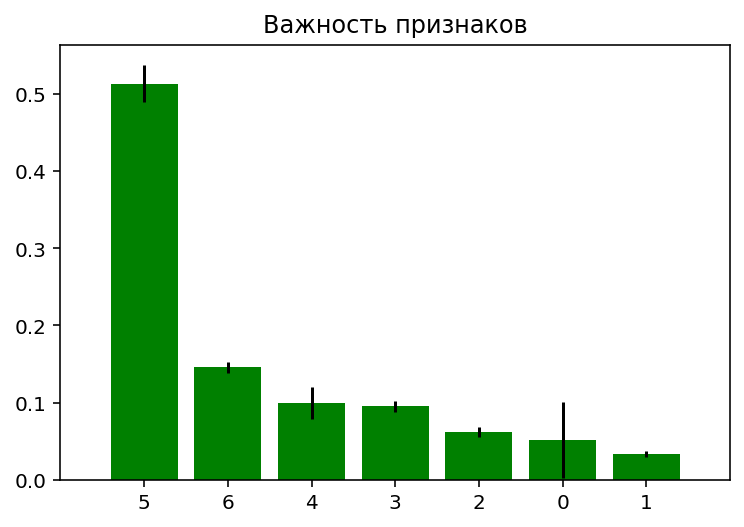

In [74]:
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Важность признаков")
plt.bar(range(X.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [ ]:
df['distance'].hist(bins = 100)

In [ ]:
corr = df[features].corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)